In [ ]:
import numpy as np
import pandas as pd
import os
from random import shuffle
import cv2
import time
import seaborn as sns
import matplotlib.pyplot as plt
import glob as gb
%matplotlib inline


In [ ]:
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
train_image = "dataset/train"
test_image = "dataset/test"


print(train_image)
print(test_image)

dataset/train
dataset/test


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [ ]:
vgg16 = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in vgg16.layers:
  layer.trainable = False

x = vgg16.output
x = AveragePooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg16.input, outputs=x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
from keras import backend as K
def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision
def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall
def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for train, test in kfold.split(train_image):
    opt=Adam(learning_rate=0.001)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[precision_threshold(threshold = 0.5), 
                       recall_threshold(threshold = 0.5), 
                       fbeta_score_threshold(beta=0.5, threshold = 0.5),
                      'accuracy','AUC',])
    
    train_generator = train_datagen.flow_from_directory(train_image,
                                                 target_size = (224,224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

    test_generator = test_datagen.flow_from_directory(test_image,
                                            target_size = (224,224),
                                            batch_size = 16,
                                            class_mode = 'categorical',
                                            shuffle = False)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')          
    start=time.time()
    history = model.fit(train_generator,
                              validation_data=test_generator,
                              epochs=25,callbacks=[earlystop]) 
    print("training time: %.2f minutes"%((time.time()-start)/60))
    
    scores = model.evaluate(test_generator)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
Epoch 1/25
322/322 [==============================] - 814s 3s/step - loss: 0.3116 - precision: 0.8907 - recall: 0.8764 - fbeta_score: 0.8874 - accuracy: 0.8841 - auc: 0.9725 - val_loss: 0.2586 - val_precision: 0.8956 - val_recall: 0.8935 - val_fbeta_score: 0.8951 - val_accuracy: 0.8936 - val_auc: 0.9803
Epoch 2/25
322/322 [==============================] - 779s 2s/step - loss: 0.2105 - precision: 0.9252 - recall: 0.9202 - fbeta_score: 0.9242 - accuracy: 0.9232 - auc: 0.9863 - val_loss: 0.1761 - val_precision: 0.9297 - val_recall: 0.9282 - val_fbeta_score: 0.9294 - val_accuracy: 0.9286 - val_auc: 0.9904
Epoch 3/25
322/322 [==============================] - 762s 2s/step - loss: 0.1761 - precision: 0.9377 - recall: 0.9350 - fbeta_score: 0.9371 - accuracy: 0.9370 - auc: 0.9899 - val_loss: 0.2485 - val_precision: 0.9082 - val_recall: 0.9082 - val_fbeta_score: 0.9082 - val_accuracy: 0.9076 - val_auc: 0.9816
E

In [ ]:
final_Test_Accuracy=np.mean(cvscores)
final_Test_Accuracy

92.11214065551758

In [ ]:
test_generator.reset() 
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=-1)
sum(y_pred==test_generator.classes)/10000


Instructions for updating:
Please use Model.predict, which supports generators.


0.1184

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_generator.classes,y_pred)

array([[102,  10,   4],
       [  0, 302,  15],
       [  0,  75, 780]], dtype=int64)

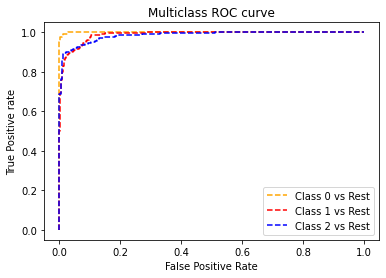

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_generator.classes, Y_pred[:,i], pos_label=i)
       
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='red', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    
